# About
This notebook calculates subcellular localization by taking proteins in the bottom 30% and top 70% (<b>Fig. 3H</b>)

In [11]:
import numpy as np
import matplotlib
import os, sys

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
	
# Set such that PDF fonts export in a manner that they
# are editable in illustrator/affinity
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# set to define axes linewidths
matplotlib.rcParams['axes.linewidth'] = 0.5

# this defines some prefactors so inline figures look nice
# on a retina macbook. These can be commented out without any
# issue and are solely asthetic.
%matplotlib inline
%config InlineBackend.figure_format='retina'

# UPDATE 2020-12-31 (my preferred font is Avenir...)
font = {'family' : 'arial',
    	'weight' : 'normal'}

matplotlib.rc('font', **font)

from tqdm import tqdm
import pickle
from sparrow import Protein
import protfasta

from scipy.cluster.hierarchy import dendrogram, linkage, leaves_list,fcluster
import matplotlib.patches as mpatches

import itertools
import metapredict as meta

from shephard.interfaces import si_proteins
from shephard import Proteome
from scipy.stats import ttest_ind

from collections import Counter

def cast_attributes(obj, include=[], exclude=[], cast_type=float):
    if len(include) > 0:
        for a in include:
            if a in obj.attributes:
                obj.add_attribute(a, cast_type(obj.attribute(a)), safe=False)
    if len(exclude) > 0:
        for a in obj.attributes:
            if a not in exclude:                
                obj.add_attribute(a, cast_type(obj.attribute(a)), safe=False)
                

def peval(pval,n=1):
    if pval < 0.00001/n:
        return('****')
    elif pval < 0.0001/n:
        return('***')
    elif pval < 0.001/n:
        return('**')
    elif pval < 0.01/n:
        return('*')
    else:
        return('ns')


# lets you import from the code directory here
local_code_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'code'))

if local_code_path not in sys.path:
    sys.path.append(local_code_path)


In [12]:
from common_functions import annotate_with_quantiles

In [13]:
yp = Proteome()
si_proteins.add_proteins_from_file(yp,'../data/experimental_data/shprd_proteome_soluble_only_v2.tsv')
# cast protein attributes 
for p in yp:
    cast_attributes(p, exclude=['lip_color', 'non_ref_score', 'refoldable', 'non_ref','membrane_protein', 'subcellular_localization'])

quantiles = annotate_with_quantiles(yp,proteins_with_domains=False)
print(quantiles)
    
    

Sanity check number of proteins in each group
[404, 404, 403, 403, 403, 403, 403, 403]
[6, 18, 30, 42, 54, 66, 78, 90]


In [15]:
subcellular_soluble = []
subcellular_insoluble = []
all_proteins = []
for p in yp:
    if int(p.attribute('quantile')) <= 30:
        subcellular_insoluble.extend([x.strip() for x in p.attribute('subcellular_localization').split(',')])
    elif int(p.attribute('quantile')) >= 60:        
        subcellular_soluble.extend([x.strip() for x in p.attribute('subcellular_localization').split(',')])
    
    all_proteins.extend([x.strip() for x in p.attribute('subcellular_localization').split(',')])

# remove unannotated
subcellular_insoluble = [x for x in subcellular_insoluble if len(x) >0]
subcellular_soluble = [x for x in subcellular_soluble if len(x) >0]
all_proteins = [x for x in all_proteins if len(x) >0]


In [16]:
names = ['nucleus', 'cytoplasm', 'mitochondrion', 'nucleolus']

In [17]:
total_c = len(all_proteins)
expected_all = []
for n in names:
    expected_all.append(Counter(all_proteins)[n]/total_c)

In [18]:
total_c = len(subcellular_insoluble)
expected_insoluble = []
for n in names:
    expected_insoluble.append(Counter(subcellular_insoluble)[n]/total_c)

In [19]:
total_c = len(subcellular_soluble)
expected_soluble = []
for n in names:
    expected_soluble.append(Counter(subcellular_soluble)[n]/total_c)

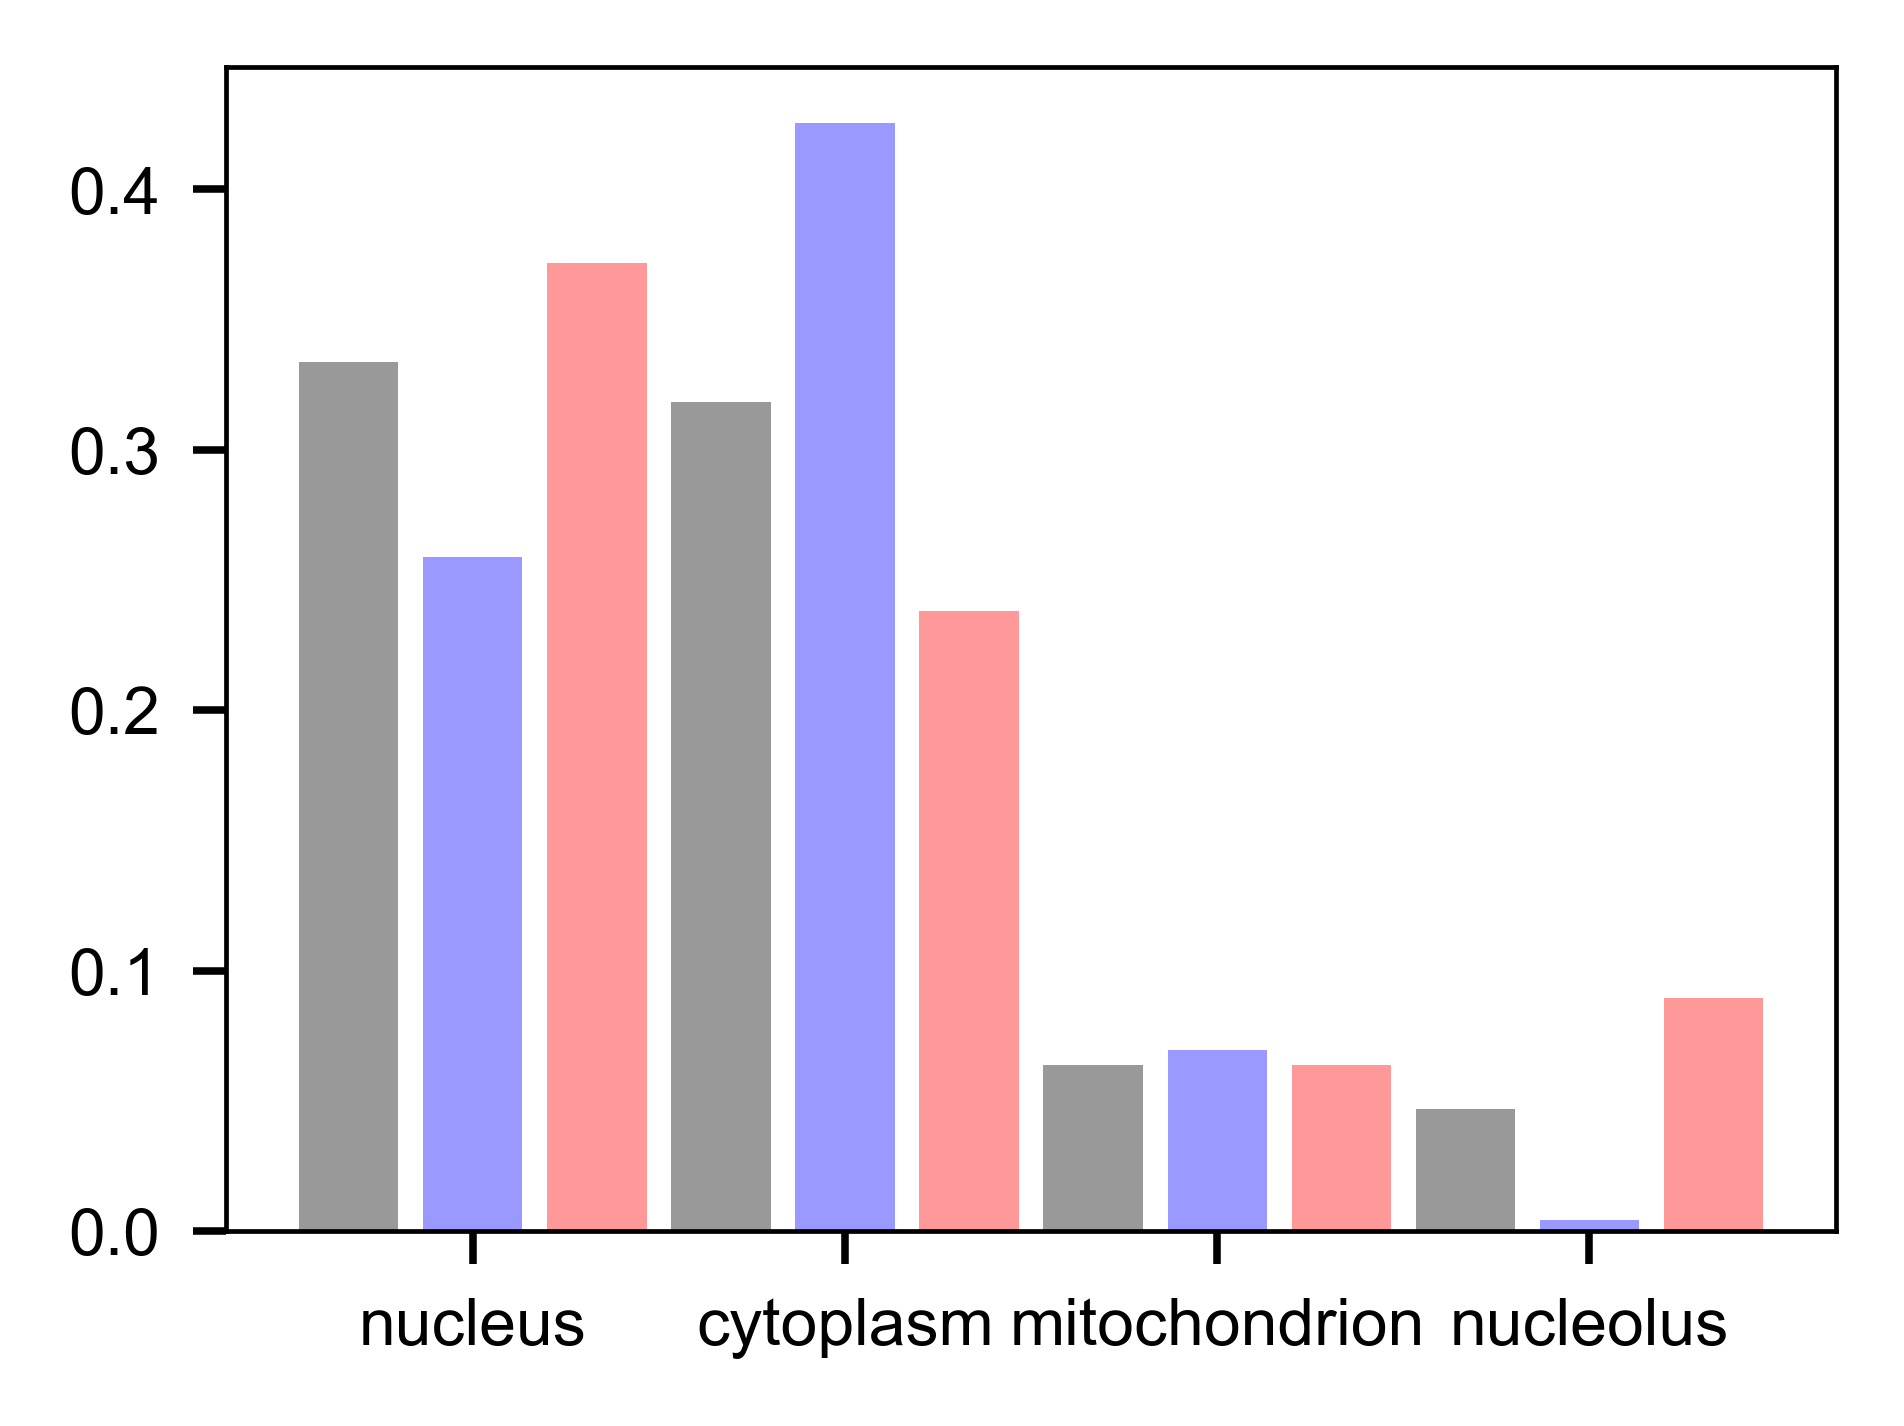

In [20]:
figure(None, (2.9,2.2), dpi=340)
plt.bar(list(range(1,len(names)*3,3)), expected_all, color='k', alpha=0.4)
plt.bar(list(range(2,(len(names)*3)+1,3)), expected_soluble, color='b', alpha=0.4)
plt.bar(list(range(3,(len(names)*3)+2,3)), expected_insoluble, color='r', alpha=0.4)
plt.xticks(list(range(2,(len(names)*3)+1,3)), names, fontsize=7)
plt.yticks(fontsize=7)
plt.tight_layout()
plt.savefig('outfigures/subcellular_localization.pdf')
